In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [6]:
%matplotlib inline

In [7]:
def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0) + 0.0000000000000000001  # avoid division by zero
    return i/u

In [8]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [9]:
def f2(masks_true, masks_pred):
    # a correct prediction on no ships in image would have F2 of zero (according to formula),
    # but should be rewarded as 1

    if np.sum(masks_true) == np.sum(masks_pred) == 0:
        return 1.0, 0, 0, 0
    
    
    f2_total = 0
    tps = np.zeros(len(thresholds))
    fps = np.zeros(len(thresholds))
    fns = np.zeros(len(thresholds))
    for index, t in enumerate(thresholds):
        tp,fp,fn = 0,0,0
        ious = {}
        for i,mt in enumerate(masks_true):
            found_match = False
            for j,mp in enumerate(masks_pred):
                miou = iou(mt, mp)
                ious[100*i+j] = miou # save for later
                if miou >= t:
                    found_match = True
            if not found_match:
                fn += 1
                
        for j,mp in enumerate(masks_pred):
            found_match = False
            for i, mt in enumerate(masks_true):
                miou = ious[100*i+j]
                if miou >= t:
                    found_match = True
                    break
            if found_match:
                tp += 1
            else:
                fp += 1
        tps[index] = tp
        fps[index] = fp
        fns[index] = fn
        f2 = (5*tp)/(5*tp + 4*fn*fp)
        f2_total += f2
    
    return f2_total/len(thresholds), tps, fns, fps

In [10]:
"""
2af1bd87c.jpg　複数船
eda8ac87d.jpg なし
0a2e15e29.jpg　多数
0bd7ad77f.jpg　小さい


"""
def show_score(img_name, th):
    gen_img = cv2.imread("./val/generate/{}".format(img_name), 0)
    gen_img = cv2.resize(gen_img, (768, 768))
    _, gen_img_th = cv2.threshold(gen_img,255*th,255,cv2.THRESH_BINARY)
    label_img = cv2.imread("./val/label/{}".format(img_name), 0)
    label_img = cv2.resize(label_img, (768, 768))
    original_img = cv2.imread('./val/original/{}'.format(img_name))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    iou_score = iou(label_img, gen_img_th)
    f2_score, tps, fns, fps = f2([label_img], [gen_img_th])
    print("iou: {}, f2: {}".format(iou_score, f2_score))
    print("thresholds: {}".format(thresholds))
    print("tp: {}".format(tps))
    print("fp: {}".format(fps))
    print("fn: {}".format(fns))

    fig, axarr = plt.subplots(1, 4, figsize=(15, 40))
    axarr[0].imshow(original_img)
    plt.gray()
    axarr[1].imshow(gen_img)
    axarr[2].imshow(gen_img_th)
    axarr[3].imshow(label_img)
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

iou: 0.3706896551724138, f2: 0.0
thresholds: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
tp: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
fp: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
fn: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


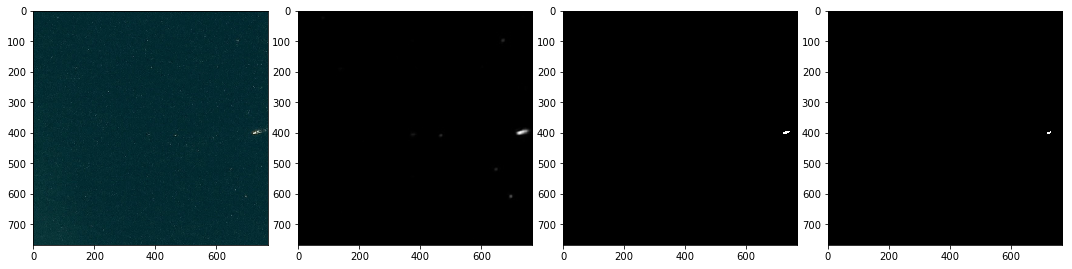

In [87]:
show_score("0bd7ad77f.jpg", 0.5)

In [19]:
def calc_all_score(mode=0):
    N = 3200 #合計画像枚数
    th = 0.5
    img_names = os.listdir('./val/generate')
    f2_score_all = 0
    tp_all = 0
    fn_all = 0
    fp_all = 0
    for index, img_name in enumerate(img_names):
        if index % 500 == 0:
            print(index)
        gen_img = cv2.imread("./val/generate/{}".format(img_name), 0)
        gen_img = cv2.resize(gen_img, (768, 768))
        _, gen_img_th = cv2.threshold(gen_img,255*th,255,cv2.THRESH_BINARY)
        if mode == 1:
            gen_img_th = approximate_img(gen_img_th, 0.025)
        if mode == 2:
            gen_img_th = approximate_img2(gen_img_th)
        
        label_img = cv2.imread("./val/label/{}".format(img_name), 0)
        label_img = cv2.resize(label_img, (768, 768))
        
        f2_score, tps, fns, fps = f2([label_img], [gen_img_th])
        f2_score_all += f2_score
        tp_all += np.sum(tps)
        fn_all += np.sum(fns)
        fp_all += np.sum(fps)

    print("f2: {}, tp: {}, fn: {}, fp: {}".format(f2_score_all/N, tp_all, fn_all, fp_all))

In [18]:
calc_all_score(2)

0
500
1000
1500
2000
2500
3000
f2: 0.8472812500000001, tp: 4313.0, fn: 4887.0, fp: 4887.0


In [1]:
def  approximate_img(_img, eps):
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        epsilon = eps*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        result_img = cv2.fillConvexPoly(result_img, approx, 1)
    return result_img

In [2]:
def  approximate_img2(_img):
    _, contours, _ = cv2.findContours(_img, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    result_img = np.zeros_like(_img)
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        result_img = cv2.fillConvexPoly(result_img, box, 1)
    return result_img

In [22]:
def mean_iou(mode):
    img_names = os.listdir('./val/generate')
    sum_iou = 0
    th = 0.5
    for index, img_name in enumerate(img_names):
        if index % 500 == 0:
            print(index)
        gen_img = cv2.imread("./val/generate/{}".format(img_name), 0)
        gen_img = cv2.resize(gen_img, (768, 768))
        _, gen_img_th = cv2.threshold(gen_img,255*th,255,cv2.THRESH_BINARY)
        if mode == 1:
            gen_img_th = approximate_img(gen_img_th, 0.025)
        if mode == 2:
            gen_img_th = approximate_img2(gen_img_th)
        
        label_img = cv2.imread("./val/label/{}".format(img_name), 0)
        label_img = cv2.resize(label_img, (768, 768))
        
        sum_iou += iou(label_img, gen_img_th)
    print("mean iou = {}".format(sum_iou/len(img_names)))

In [25]:
mean_iou(2)

0
500
1000
1500
2000
2500
3000
mean iou = 0.30437063842906326
